In [ ]:
import numpy as np
from scipy.sparse import linalg as LA
from scipy.sparse import csr_matrix
import time
import matplotlib.pyplot as plt
import random

def bicut_group(laplacian_matrix, indices=None):
    """
    Enhanced spectral clustering function that returns both sign-based and optimal cuts.
    
    Args:
        laplacian_matrix: numpy array, the full graph Laplacian matrix
        indices: list of indices to consider for this cut
        threshold: float, threshold for determining if groups should be split
    
    Returns:
        tuple: (first_group, second_group) where second_group may be empty
    """

    if indices is None:
        indices = list(range(len(laplacian_matrix)))

    # Extract submatrix for current indices
    sub_laplacian = laplacian_matrix[np.ix_(indices, indices)]
    
    # Basis steps
    if len(indices) <= 1:
        return indices, []
    if len(indices) == 2:
        return [indices[0]], [indices[1]]
    
    # Get Fiedler vector and sort vertices
    _, eigenvecs = LA.eigsh(sub_laplacian,k=2,which = 'SA')
    
    # Find the second smallest eigenvalue (Fiedler value)
    fiedler_vector = eigenvecs[:, 1]
    sorted_args = np.argsort(fiedler_vector)
    
    # Reorder adjacency matrix
    adj = -sub_laplacian[np.ix_(sorted_args,sorted_args)]  # Full adjacency matrix
    
    # Find best cut
    n = len(indices)
    qualities = np.zeros(n-1)
    for i in range(1, n):
        qualities[i-1] = np.sum(adj[i:,:i]) / (i * (n - i))
    
    best_cut = np.argmin(qualities) + 1
    
    # Get the groups based on sorted indices
    first_group = [indices[j] for j in sorted_args[:best_cut]]
    second_group = [indices[j] for j in sorted_args[best_cut:]]

    # first_group.sort()
    # second_group.sort()
    # Continue with the split
    if 0 in first_group:
        return first_group, second_group
    return second_group, first_group

def generate_test_laplacian(size1, size2, prob1, prob2, prob_between):
    """
    Generate a random Laplacian matrix for testing spectral clustering.
    
    Args:
        size1: size of first group
        size2: size of second group  
        prob1: probability of edge within first group
        prob2: probability of edge within second group
        prob_between: probability of edge between groups
    
    Returns:
        numpy array: Laplacian matrix L = D - A
    """
    n = size1 + size2
    adj = np.zeros((n, n))
    
    # Generate edges within first group (0 to size1-1)
    for i in range(size1):
        for j in range(i+1, size1):
            if np.random.random() < prob1:
                adj[i, j] = adj[j, i] = 1
    
    # Generate edges within second group (size1 to n-1)
    for i in range(size1, n):
        for j in range(i+1, n):
            if np.random.random() < prob2:
                adj[i, j] = adj[j, i] = 1
    
    # Generate edges between groups
    for i in range(size1):
        for j in range(size1, n):
            if np.random.random() < prob_between:
                adj[i, j] = adj[j, i] = 1
    
    # Create Laplacian matrix L = D - A
    degree = np.sum(adj, axis=1)
    laplacian = np.diag(degree) - adj
    
    return laplacian

def test_clustering_accuracy(size1, size2, prob1, prob2, prob_between, num_tests=10):
    """
    Test the accuracy of spectral clustering on generated graphs.
    
    Returns:
        float: accuracy rate (0 to 1)
    """
    correct = 0
    
    for _ in range(num_tests):
        # Generate test graph
        L = generate_test_laplacian(size1, size2, prob1, prob2, prob_between)
        
        # Run clustering
        predicted_group, _ = bicut_group(L)
        predicted_group.sort()
        
        # True first group is [0, 1, ..., size1-1]
        true_group = list(range(size1))

        if predicted_group == true_group:
            correct += 1
    
    return correct / num_tests


# Example usage and test
if __name__ == "__main__":
    # Test with generated graphs
    print("\n=== Testing with Generated Graphs ===")
    
    # Test accuracy over multiple runs
    print(f"\nAccuracy on easy case (high separation):", end=" ")
    accuracy_easy = test_clustering_accuracy(size1=100, size2=100, prob1=0.75, prob2=0.75, prob_between=0.4, num_tests=20)
    print(f"{accuracy_easy:.2%}")
    
    print(f"\nAccuracy on hard case (low separation):", end=" ")
    accuracy_hard = test_clustering_accuracy(size1=100, size2=100, prob1=0.30, prob2=0.30, prob_between=0.1, num_tests=20)
    print(f"{accuracy_hard:.2%}")


=== Testing with Generated Graphs ===

Accuracy on easy case (high separation): 100.00%

Accuracy on hard case (low separation): 85.00%


In [8]:
def generate_multi_group_laplacian(num_groups, group_size, prob_within, prob_between):
    """
    Generate a Laplacian matrix for multiple groups with uniform group sizes.
    
    Args:
        num_groups: int, number of groups
        group_size: int, number of nodes in each group
        prob_within: float, probability of edge within each group (0 to 1)
        prob_between: float, probability of edge between different groups (0 to 1)
    
    Returns:
        numpy array: Laplacian matrix L = D - A
    """
    
    # Validate inputs
    if num_groups <= 0 or group_size <= 0:
        raise ValueError("num_groups and group_size must be positive integers")
    if not (0 <= prob_within <= 1) or not (0 <= prob_between <= 1):
        raise ValueError("Probabilities must be between 0 and 1")
    
    # Calculate total number of nodes
    total_nodes = num_groups * group_size
    
    # Initialize adjacency matrix
    adj = np.zeros((total_nodes, total_nodes))
    
    # Generate edges within each group
    for group_id in range(num_groups):
        start_idx = group_id * group_size
        end_idx = (group_id + 1) * group_size
        
        # Generate all possible pairs within this group
        for i in range(start_idx, end_idx):
            for j in range(i + 1, end_idx):
                if np.random.random() < prob_within:
                    adj[i, j] = adj[j, i] = 1
    
    # Generate edges between different groups
    for group1 in range(num_groups):
        for group2 in range(group1 + 1, num_groups):
            start1, end1 = group1 * group_size, (group1 + 1) * group_size
            start2, end2 = group2 * group_size, (group2 + 1) * group_size
            
            # Generate edges between group1 and group2
            for i in range(start1, end1):
                for j in range(start2, end2):
                    if np.random.random() < prob_between:
                        adj[i, j] = adj[j, i] = 1
    
    # Create Laplacian matrix L = D - A
    degree = np.sum(adj, axis=1)
    laplacian = np.diag(degree) - adj

    return laplacian

def random_multi_group_laplacian(num_groups, group_size, prob_within, prob_between):
    import random
    lap = generate_multi_group_laplacian(num_groups, group_size, prob_within, prob_between)
    random_order = random.sample(range(len(lap)), len(lap))
    permuted_lap = lap[np.ix_(random_order, random_order)]
    return permuted_lap

def visualize_laplacian_matrix(laplacian_matrix):
    """
    Visualize a Laplacian matrix as a black and white image.
    
    Args:
        laplacian_matrix
    
    Returns:
        visualization of the connections
    """
    
    # Create binary matrix: 1 for non-zero elements, 0 for zero elements
    binary_matrix = (laplacian_matrix != 0).astype(int)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # Display the matrix: black for non-zero (1), white for zero (0)
    im = ax.imshow(binary_matrix, cmap='gray_r', interpolation='nearest')
    
    # Show the plot
    plt.show()
    
    return fig

In [9]:
class BiCutNode:
    """Node class for the bi-cut tree structure"""
    def __init__(self, indices, left=None, right=None, parent=None):
        self.indices = indices  # List of vertex indices in this node
        self.left = left       # Left subtree
        self.right = right     # Right subtree
        self.parent = parent   # Parent node
        
        # Set parent for children
        if self.left:
            self.left.parent = self
        if self.right:
            self.right.parent = self
    
    def print_fancy_tree(self, prefix="", is_last=True, is_root=True):
        """Print tree with fancy box-drawing characters"""
        if is_root:
            print("┌─ BiCut Tree Structure")
        
        connector = "├─" if is_root else ("└─" if is_last else "├─")
        indices_str = f"[{', '.join(map(str, sorted(self.indices)))}]"
        
        print(f"{prefix}{connector} {indices_str}")
        
        new_prefix = prefix + ("│  " if is_root else ("   " if is_last else "│  "))
        children = [child for child in [self.left, self.right] if child is not None]
        
        for i, child in enumerate(children):
            is_last_child = (i == len(children) - 1)
            child.print_fancy_tree(new_prefix, is_last_child, False)

    def is_leaf(self):
        return self.left is None and self.right is None
    
    def get_order(self):
        """
        Extract the order of singleton nodes (leaves with single elements)
        in the order they appear in a tree traversal.
        
        Returns:
            list: Order of singleton vertices as they appear in the tree
        """
        order = []
        
        def collect_singletons(node):
            # If this is a leaf with exactly one element, add it to order
            if node.is_leaf():
                order.append(node.indices[0])
            else:
                # Traverse children in order (left first, then right)
                if node.left:
                    collect_singletons(node.left)
                if node.right:
                    collect_singletons(node.right)
        
        collect_singletons(self)
        return order

In [10]:
def treebuilder(laplacian_matrix, indices=None):
    """
    Recursively apply bi-cut to create a tree structure.
    
    Args:
        laplacian_matrix: numpy array, the full graph Laplacian matrix
        indices: list of indices to process (None means all vertices)
    
    Returns:
        BiCutNode: Root of the bi-cut tree
    """
    if indices is None:
        indices = list(range(len(laplacian_matrix)))
    
    # Base case: empty or single vertex
    if len(indices) <= 1:
        return BiCutNode(indices)
    
    # Apply bi-cut
    first_group, second_group = bicut_group(laplacian_matrix, indices)
    
    # If second group is empty, this is a leaf node
    if not second_group:
        return BiCutNode(indices)
    
    # Create current node first
    node = BiCutNode(indices)
    
    # Recursively process subgroups
    node.left = treebuilder(laplacian_matrix, first_group)
    node.right = treebuilder(laplacian_matrix, second_group)
    
    # Explicitly set parent references (though constructor should handle this)
    if node.left:
        node.left.parent = node
    if node.right:
        node.right.parent = node
    
    return node

1 10.342991590499878
2 229.80011558532715
3 0.002515554428100586


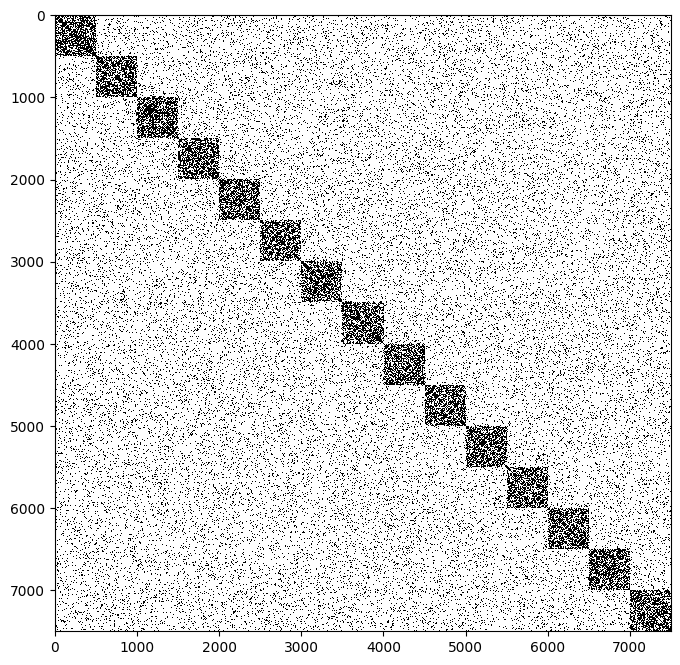

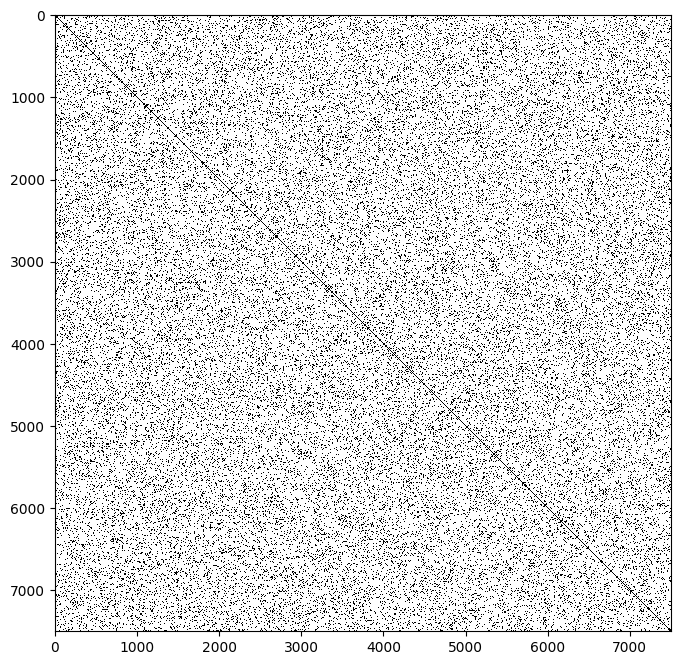

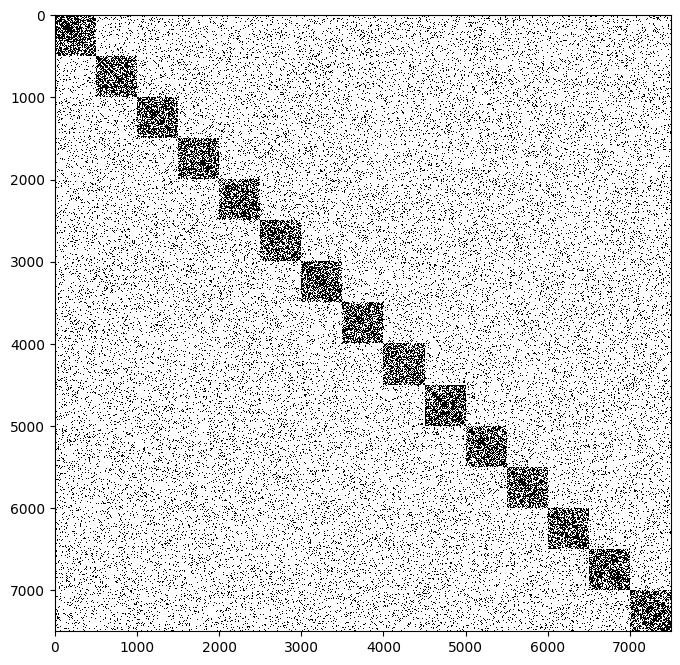

4 12.064467668533325


In [ ]:
t1 = time.time()
oL = generate_multi_group_laplacian(15, 500, .6, .1)
random_order = random.sample(range(len(oL)), len(oL))
L = oL[np.ix_(random_order, random_order)]
t2 = time.time()
print(1,t2-t1)

T = treebuilder(L)
t3 = time.time()
print(2,t3-t2)

order = T.get_order()
t4 = time.time()
print(3,t4-t3)

ordered_L = L[np.ix_(order, order)]

visualize_laplacian_matrix(oL)
visualize_laplacian_matrix(L)
visualize_laplacian_matrix(ordered_L)
t5 = time.time()
print(4,t5-t4)

1 21.006964921951294
2 633.4077365398407
3 0.0031957626342773438


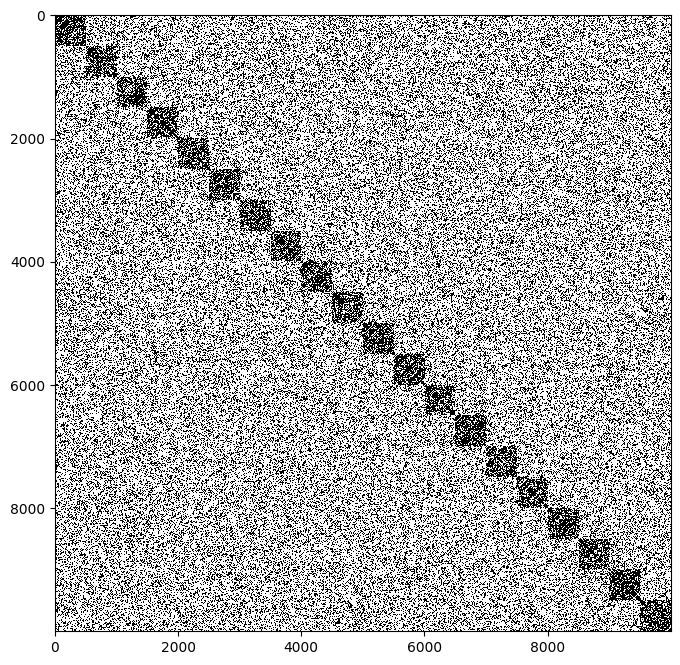

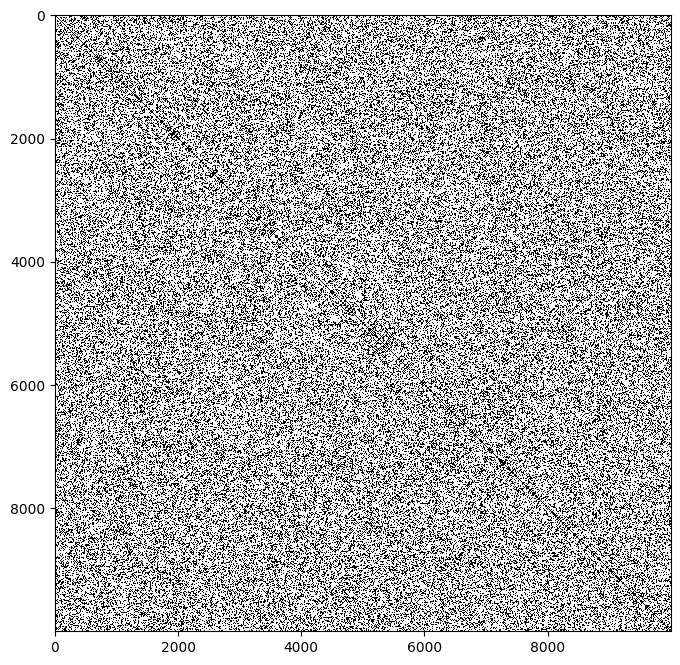

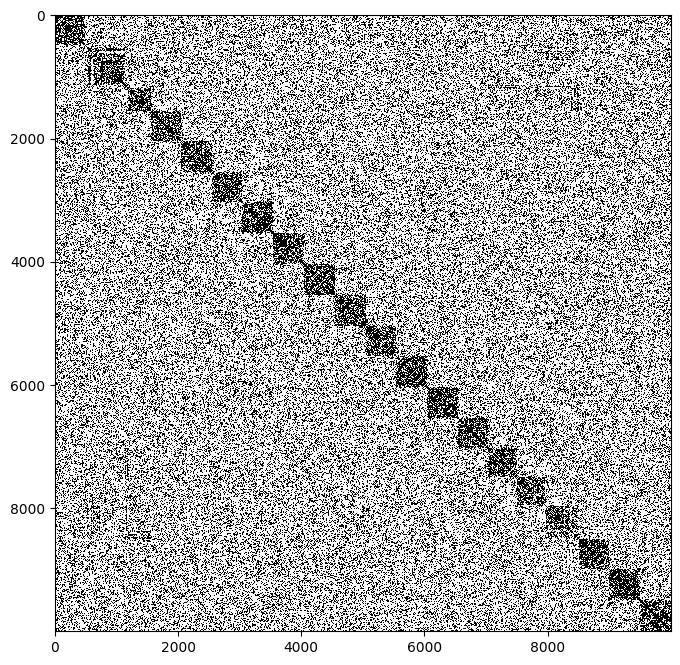

4 22.814478397369385


In [13]:
t1 = time.time()
oL = generate_multi_group_laplacian(20, 500, .7, .3)
random_order = random.sample(range(len(oL)), len(oL))
L = oL[np.ix_(random_order, random_order)]
t2 = time.time()
print(1,t2-t1)

T = treebuilder(L)
t3 = time.time()
print(2,t3-t2)

order = T.get_order()
t4 = time.time()
print(3,t4-t3)

ordered_L = L[np.ix_(order, order)]

visualize_laplacian_matrix(oL)
visualize_laplacian_matrix(L)
visualize_laplacian_matrix(ordered_L)
t5 = time.time()
print(4,t5-t4)

1 21.655306577682495
2 1212.1380004882812
3 0.0032396316528320312


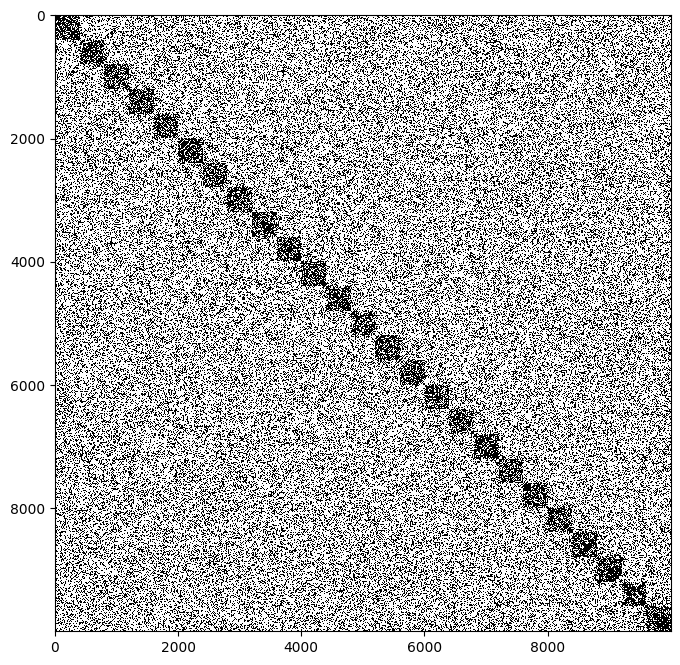

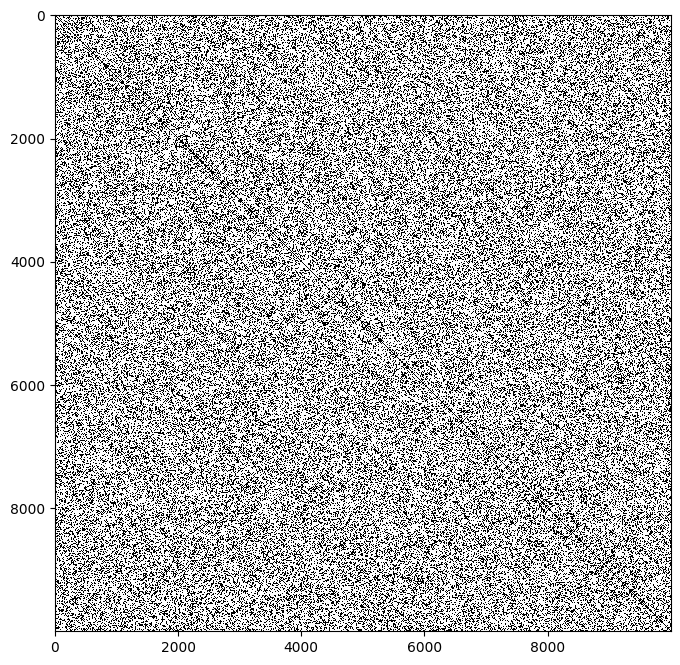

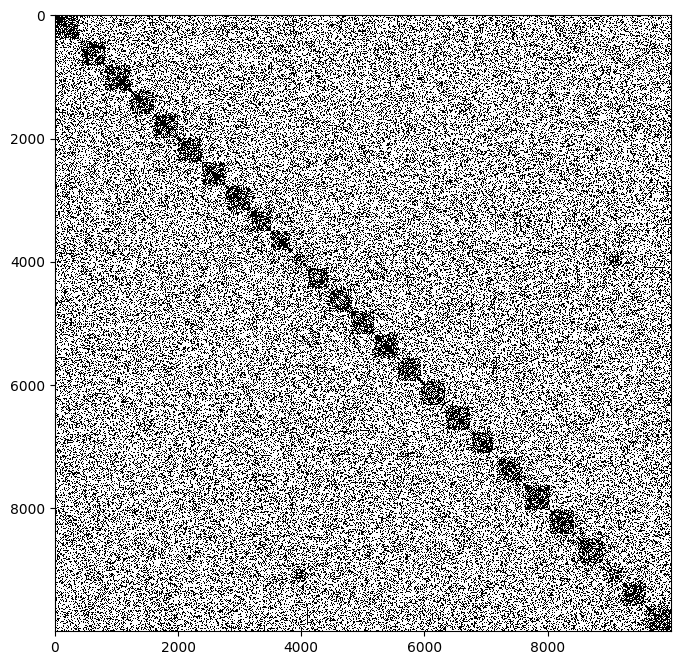

4 22.784178018569946


In [15]:
t1 = time.time()
oL = generate_multi_group_laplacian(25, 400, .7, .3)
random_order = random.sample(range(len(oL)), len(oL))
L = oL[np.ix_(random_order, random_order)]
t2 = time.time()
print(1,t2-t1)

T = treebuilder(L)
t3 = time.time()
print(2,t3-t2)

order = T.get_order()
t4 = time.time()
print(3,t4-t3)

ordered_L = L[np.ix_(order, order)]

visualize_laplacian_matrix(oL)
visualize_laplacian_matrix(L)
visualize_laplacian_matrix(ordered_L)
t5 = time.time()
print(4,t5-t4)

In [ ]:
t1 = time.time()
oL = generate_multi_group_laplacian(30, 333, .7, .3)
random_order = random.sample(range(len(oL)), len(oL))
L = oL[np.ix_(random_order, random_order)]
t2 = time.time()
print(1,t2-t1)

T = treebuilder(L)
t3 = time.time()
print(2,t3-t2)

order = T.get_order()
t4 = time.time()
print(3,t4-t3)

ordered_L = L[np.ix_(order, order)]

visualize_laplacian_matrix(oL)
visualize_laplacian_matrix(L)
visualize_laplacian_matrix(ordered_L)
t5 = time.time()
print(4,t5-t4)

1 20.923012495040894
